In [14]:
pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [15]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

In [2]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = keras.datasets.mnist.load_data()

train_3_mask = (y_train_full == 3)
train_8_mask = (y_train_full == 8)
x_train_3_8 = x_train_full[train_3_mask | train_8_mask]
y_train_3_8 = y_train_full[train_3_mask | train_8_mask]

test_3_mask = (y_test_full == 3)
test_8_mask = (y_test_full == 8)
x_test_3_8 = x_test_full[test_3_mask | test_8_mask]
y_test_3_8 = y_test_full[test_3_mask | test_8_mask]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train_3_8_norm = x_train_3_8.astype('float32') / 255.0
x_test_3_8_norm = x_test_3_8.astype('float32') / 255.0

In [4]:
y_train_3_8_binary = (y_train_3_8 == 8).astype(np.int32)
y_test_3_8_binary = (y_test_3_8 == 8).astype(np.int32)

In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train_3_8_norm, y_train_3_8_binary,
    test_size=0.2,
    stratify=y_train_3_8_binary,
    random_state=42
)

In [6]:
x_test = x_test_3_8_norm
y_test = y_test_3_8_binary

In [7]:
print(f"Total training samples (3s & 8s): {x_train_3_8_norm.shape[0]}")
print(f"Training samples after split: {x_train.shape[0]}")
print(f"Validation samples: {x_val.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print("Data preprocessing complete.\n")

Total training samples (3s & 8s): 11982
Training samples after split: 9585
Validation samples: 2397
Test samples: 1984
Data preprocessing complete.



In [8]:
def build_mlp_architecture(hp, input_shape=(28, 28), num_output_neurons=1):
    """
    Builds a flexible MLP model using Keras Sequential API.
    hp: Keras Tuner HyperParameters object (used for defining search space)
    input_shape: Shape of the input data (e.g., (28, 28) for MNIST images)
    num_output_neurons: Number of neurons in the output layer (1 for binary classification)
    """
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=input_shape)) # Explicit Input layer for clarity
    model.add(keras.layers.Flatten()) # Flattens the 2D image into a 1D vector

    # Tune the number of hidden layers (between 1 and 3)
    # This allows the tuner to decide how deep the network should be
    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        # Tune the number of units (neurons) in each hidden layer
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), # Search from 32 to 256 neurons
            # Tune the activation function for hidden layers
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
        ))
        # Optionally add a Dropout layer for regularization to prevent overfitting
        if hp.Boolean(f'dropout_{i}'):
            model.add(layers.Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer: 1 neuron with sigmoid for binary classification (3s vs 8s)
    # If it were multi-class, it would be `num_classes` and `softmax` activation.
    model.add(layers.Dense(num_output_neurons, activation='sigmoid'))

    return model

In [9]:
def build_model_for_sgd_tuner(hp):
    """
    Builds and compiles an MLP model for Keras Tuner search with SGD optimizer.
    Defines the search space for SGD's hyperparameters.
    """
    # Build the uncompiled MLP architecture
    model = build_mlp_architecture(hp, input_shape=(28, 28), num_output_neurons=1)

    # Define hyperparameter search space for SGD optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # Common learning rates
    hp_momentum = hp.Float('momentum', min_value=0.0, max_value=0.9, step=0.1) # Momentum value
    hp_nesterov = hp.Boolean('nesterov') # Whether to use Nesterov momentum

    # Compile the model with SGD optimizer
    model.compile(optimizer=SGD(learning_rate=hp_learning_rate, momentum=hp_momentum, nesterov=hp_nesterov),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [10]:
def build_model_for_adam_tuner(hp):
    """
    Builds and compiles an MLP model for Keras Tuner search with Adam optimizer.
    Defines the search space for Adam's hyperparameters.
    """
    # Build the uncompiled MLP architecture using Keras Tuner's HP object
    model = build_mlp_architecture(hp, input_shape=(28, 28), num_output_neurons=1)

    # Define hyperparameter search space for Adam optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) # Common learning rates
    hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.99, step=0.01) # Range for beta_1
    hp_beta_2 = hp.Float('beta_2', min_value=0.99, max_value=0.9999, sampling='log') # Logarithmic search for beta_2
    hp_epsilon = hp.Float('epsilon', min_value=1e-08, max_value=1e-06, sampling='log') # Logarithmic search for epsilon

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2, epsilon=hp_epsilon),
                  loss='binary_crossentropy', # Appropriate loss for binary classification
                  metrics=['accuracy']) # Track accuracy during tuning
    return model

In [11]:
def evaluate_model_metrics(model, x_test_data, y_test_data, model_name="Model", class_labels=[3, 8]):
    """
    Evaluates a trained model on the test set and calculates a range of classification metrics.

    Args:
        model (tf.keras.Model): The trained Keras model.
        x_test_data (np.array): Test features (normalized image data).
        y_test_data (np.array): True binary test labels (0s and 1s).
        model_name (str): Name of the model for printing context.
        class_labels (list): Original labels corresponding to binary mapping (e.g., [3, 8])

    Returns:
        dict: A dictionary containing various evaluation metrics.
    """
    print(f"\n--- Detailed Evaluation for {model_name} on Test Set ---")

    y_pred_proba = model.predict(x_test_data, verbose=0).flatten()
    y_pred_binary_classes = (y_pred_proba > 0.5).astype(int)

    loss, accuracy = model.evaluate(x_test_data, y_test_data, verbose=0)

    precision = precision_score(y_test_data, y_pred_binary_classes)
    recall = recall_score(y_test_data, y_pred_binary_classes)
    f1 = f1_score(y_test_data, y_pred_binary_classes)

    # ROC AUC requires probabilities
    # Handle potential errors if ROC AUC cannot be computed (e.g., all same class)
    try:
        roc_auc = roc_auc_score(y_test_data, y_pred_proba)
    except ValueError as e:
        print(f"Warning: Could not calculate ROC AUC ({e}). This might happen if only one class is present in y_true or y_score.")
        roc_auc = np.nan # Assign NaN if calculation fails

    print(f"  Test Loss: {loss:.4f}")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  Test Precision: {precision:.4f}")
    print(f"  Test Recall: {recall:.4f}")
    print(f"  Test F1-Score: {f1:.4f}")
    print(f"  Test ROC AUC: {roc_auc:.4f}")

    print("\nClassification Report:")

    print(classification_report(y_test_data, y_pred_binary_classes, target_names=[f'Class {class_labels[0]}', f'Class {class_labels[1]}']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_data, y_pred_binary_classes)
    print(cm)

    metrics = {
        'test_loss': loss,
        'test_accuracy': accuracy,
        'test_precision': precision,
        'test_recall': recall,
        'test_f1_score': f1,
        'test_roc_auc': roc_auc,
    }
    return metrics

In [27]:
def run_sgd_experiment(config, x_train_data, y_train_data, x_val_data, y_val_data, x_test_data, y_test_data):
    """
    Runs a single SGD experiment with specified configuration.
    """
    print(f"\n--- Running SGD Experiment: {config} ---")

    # Set random seed for reproducibility
    tf.keras.utils.set_random_seed(config.get('random_seed', 42))

    # Build the model dynamically based on the 'num_hidden_layers' from the config
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())

    for i in range(config['num_hidden_layers']):
        model.add(layers.Dense(
            units=config[f'units_{i}'], # Correctly access units for layer i
            activation=config[f'activation_{i}'] # Correctly access activation for layer i
        ))
        # Add dropout layer if it was part of the best HP config for this layer
        if config.get(f'dropout_{i}', False): # Check if dropout was enabled for this specific layer
            model.add(layers.Dropout(config[f'dropout_rate_{i}']))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Initialize SGD optimizer with parameters from the config
    sgd_optimizer = SGD(
        learning_rate=config['learning_rate'],
        momentum=config['momentum'],
        nesterov=config.get('nesterov', False) # Nesterov might not be in all configs if it was boolean tuned
    )

    # Compile the model
    model.compile(optimizer=sgd_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    # Train the model
    history = model.fit(
        x_train_data, y_train_data,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(x_val_data, y_val_data),
        verbose=1 # Show epoch-by-epoch output
    )

    end_time = time.time()
    total_training_time = end_time - start_time

    # Evaluate model using the robust evaluation function
    evaluation_metrics = evaluate_model_metrics(model, x_test_data, y_test_data, model_name=f"SGD Run (Seed: {config.get('random_seed', 'N/A')})")

    # Collect all results
    results = {
        'optimizer': 'SGD',
        'learning_rate': config['learning_rate'],
        'momentum': config['momentum'],
        'nesterov': config.get('nesterov', False),
        'num_hidden_layers': config['num_hidden_layers'], # Include this as a key
        'epochs': config['epochs'],
        'batch_size': config['batch_size'],
        'random_seed': config.get('random_seed', 'N/A'),
        'train_accuracy_final': history.history['accuracy'][-1],
        'val_accuracy_final': history.history['val_accuracy'][-1],
        'train_loss_final': history.history['loss'][-1],
        'val_loss_final': history.history['val_loss'][-1],
        'training_time_sec': total_training_time,
        **evaluation_metrics # Add all robust metrics
    }
    # Dynamically add details for each hidden layer to the results dictionary
    for i in range(config['num_hidden_layers']):
        results[f'units_{i}'] = config[f'units_{i}']
        results[f'activation_{i}'] = config[f'activation_{i}']
        if config.get(f'dropout_{i}', False): # Check if dropout was enabled for this specific layer
            results[f'dropout_rate_{i}'] = config[f'dropout_rate_{i}']

    return results, history

In [26]:
def run_adam_experiment(config, x_train_data, y_train_data, x_val_data, y_val_data, x_test_data, y_test_data):
    """
    Runs a single Adam experiment with specified configuration.
    """
    print(f"\n--- Running Adam Experiment: {config} ---")

    # Set random seed for reproducibility of this specific run
    tf.keras.utils.set_random_seed(config.get('random_seed', 42))

    # Build the model dynamically based on the 'num_hidden_layers' from the config
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(28, 28)))
    model.add(keras.layers.Flatten())

    for i in range(config['num_hidden_layers']):
        model.add(layers.Dense(
            units=config[f'units_{i}'], # Correctly access units for layer i
            activation=config[f'activation_{i}'] # Correctly access activation for layer i
        ))
        # Add dropout layer if it was part of the best HP config for this layer
        if config.get(f'dropout_{i}', False): # Check if dropout was enabled for this specific layer
            model.add(layers.Dropout(config[f'dropout_rate_{i}']))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Initialize Adam optimizer with parameters from the config
    adam_optimizer = Adam(
        learning_rate=config['learning_rate'],
        beta_1=config['beta_1'],
        beta_2=config['beta_2'],
        epsilon=config['epsilon']
    )

    # Compile the model
    model.compile(optimizer=adam_optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()

    # Train the model
    history = model.fit(
        x_train_data, y_train_data,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(x_val_data, y_val_data),
        verbose=1 # Show epoch-by-epoch output
    )

    end_time = time.time()
    total_training_time = end_time - start_time

    # Evaluate model using the robust evaluation function
    evaluation_metrics = evaluate_model_metrics(model, x_test_data, y_test_data, model_name=f"Adam Run (Seed: {config.get('random_seed', 'N/A')})")

    # Collect all results
    results = {
        'optimizer': 'Adam',
        'learning_rate': config['learning_rate'],
        'beta_1': config['beta_1'],
        'beta_2': config['beta_2'],
        'epsilon': config['epsilon'],
        'num_hidden_layers': config['num_hidden_layers'], # Include this as a key
        'epochs': config['epochs'],
        'batch_size': config['batch_size'],
        'random_seed': config.get('random_seed', 'N/A'),
        'train_accuracy_final': history.history['accuracy'][-1],
        'val_accuracy_final': history.history['val_accuracy'][-1],
        'train_loss_final': history.history['loss'][-1],
        'val_loss_final': history.history['val_loss'][-1],
        'training_time_sec': total_training_time,
        **evaluation_metrics # Add all robust metrics
    }
    # Dynamically add details for each hidden layer to the results dictionary
    for i in range(config['num_hidden_layers']):
        results[f'units_{i}'] = config[f'units_{i}']
        results[f'activation_{i}'] = config[f'activation_{i}']
        if config.get(f'dropout_{i}', False): # Check if dropout was enabled for this specific layer
            results[f'dropout_rate_{i}'] = config[f'dropout_rate_{i}']

    return results, history

In [28]:
print("\n--- Starting Keras Tuner search for best SGD hyperparameters ---")
sgd_tuner = kt.Hyperband(
    hypermodel=build_model_for_sgd_tuner,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='keras_tuner_dir',
    project_name='sgd_mlp_tuning',
    overwrite=True
)

# Run the search for SGD
print("\n--- SGD Tuner Search Space Summary ---")
sgd_tuner.search_space_summary()
sgd_tuner.search(x_train, y_train,
                 epochs=15,
                 validation_data=(x_val, y_val),
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                 verbose=1)

# Get the best SGD hyperparameters
best_sgd_hps = sgd_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest SGD Hyperparameters found by Keras Tuner: {best_sgd_hps.values}")

# Get the best SGD model
best_sgd_model_from_tuner = sgd_tuner.get_best_models(num_models=1)[0]
print("Best SGD model from tuner summary:")
best_sgd_model_from_tuner.summary()

Trial 30 Complete [00h 00m 18s]
val_accuracy: 0.9637046456336975

Best val_accuracy So Far: 0.9879015684127808
Total elapsed time: 00h 03m 47s

Best SGD Hyperparameters found by Keras Tuner: {'num_hidden_layers': 3, 'units_0': 160, 'activation_0': 'tanh', 'dropout_0': True, 'learning_rate': 0.01, 'momentum': 0.4, 'nesterov': False, 'dropout_rate_0': 0.0, 'units_1': 224, 'activation_1': 'tanh', 'dropout_1': False, 'dropout_rate_1': 0.0, 'units_2': 96, 'activation_2': 'relu', 'dropout_2': True, 'dropout_rate_2': 0.0, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020'}
Best SGD model from tuner summary:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 160)            │       125,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        36,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        21,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,361 (716.25 KB)

 Trainable params: 183,361 (716.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
print("\n--- Starting Keras Tuner search for best Adam hyperparameters ---")

# Hyperband is an efficient tuning algorithm
adam_tuner = kt.Hyperband(
    hypermodel=build_model_for_adam_tuner, # The function that builds and compiles models for Adam
    objective='val_accuracy',              # Metric to optimize (maximize validation accuracy)
    max_epochs=15,                         # Max epochs a single trial can train for during search
    factor=3,                              # Reduction factor for Hyperband (how many models to keep)
    directory='keras_tuner_dir',           # Directory to save tuning results
    project_name='adam_mlp_tuning',        # Project name for organization
    overwrite=True                         # Set to False if you want to resume a previous search
)

# Run the search: This will train many models with different HPs on a subset of epochs
print("\n--- Adam Tuner Search Space Summary ---")
adam_tuner.search_space_summary()
adam_tuner.search(x_train, y_train,
                  epochs=15, # Max epochs to train each model during the search
                  validation_data=(x_val, y_val),
                  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)], # Stop early if validation loss plateaus
                  verbose=1)

# Get the best Adam hyperparameters (the single best set)
best_adam_hps = adam_tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest Adam Hyperparameters found by Keras Tuner: {best_adam_hps.values}")

# Get the best Adam model (the actual trained model from the best trial)
best_adam_model_from_tuner = adam_tuner.get_best_models(num_models=1)[0]
print("Best Adam model from tuner summary:")
best_adam_model_from_tuner.summary()

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.9895703196525574

Best val_accuracy So Far: 0.9933249950408936
Total elapsed time: 00h 03m 42s

Best Adam Hyperparameters found by Keras Tuner: {'num_hidden_layers': 2, 'units_0': 192, 'activation_0': 'relu', 'dropout_0': True, 'learning_rate': 0.0001, 'beta_1': 0.87, 'beta_2': 0.9907794282384538, 'epsilon': 4.3101901634433396e-07, 'units_1': 96, 'activation_1': 'relu', 'dropout_1': False, 'dropout_rate_0': 0.30000000000000004, 'dropout_rate_1': 0.30000000000000004, 'units_2': 160, 'activation_2': 'tanh', 'dropout_2': False, 'dropout_rate_2': 0.2, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}
Best Adam model from tuner summary:


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │       150,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,345 (661.50 KB)

 Trainable params: 169,345 (661.50 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
print("\n--- Evaluating Top N Best SGD Models (from Tuner) on Test Set ---")
top_N_sgd_hps = sgd_tuner.get_best_hyperparameters(num_trials=5)
top_N_sgd_models = sgd_tuner.get_best_models(num_models=5)

sgd_top_tuner_results = []
for i, model in enumerate(top_N_sgd_models):
    print(f"\n--- Evaluating SGD Tuner Model (Rank {i+1}) ---")
    metrics = evaluate_model_metrics(model, x_test, y_test, model_name=f"SGD Tuner Top {i+1}")
    metrics['rank'] = i + 1
    metrics['hyperparameters'] = top_N_sgd_hps[i].values
    sgd_top_tuner_results.append(metrics)

sgd_top_tuner_results_df = pd.DataFrame(sgd_top_tuner_results)
print("\nTop N SGD Models Summary (from Tuner Search):")
print(sgd_top_tuner_results_df)


--- Evaluating Top N Best SGD Models (from Tuner) on Test Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 8 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- Evaluating SGD Tuner Model (Rank 1) ---

--- Detailed Evaluation for SGD Tuner Top 1 on Test Set ---
  Test Loss: 0.0463
  Test Accuracy: 0.9854
  Test Precision: 0.9846
  Test Recall: 0.9856
  Test F1-Score: 0.9851
  Test ROC AUC: 0.9982

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.98      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[995  15]
 [ 14 960]]

--- Evaluating SGD Tuner Model (Rank 2) ---

--- Detailed Evaluation for SGD Tuner Top 2 on Test Set ---
  Test Loss: 0.0497
  Test Accuracy: 0.9834
  Test Precision: 0.9866
  Test Recall: 0.9795
  Test F1-Score: 0.9830
  Test ROC AUC: 0.9978

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.98      0.99      0

In [31]:
print("\n--- Evaluating Top N Best Adam Models (from Tuner) on Test Set ---")
top_N_adam_hps = adam_tuner.get_best_hyperparameters(num_trials=5)
top_N_adam_models = adam_tuner.get_best_models(num_models=5)

adam_top_tuner_results = []
for i, model in enumerate(top_N_adam_models):
    print(f"\n--- Evaluating Adam Tuner Model (Rank {i+1}) ---")
    metrics = evaluate_model_metrics(model, x_test, y_test, model_name=f"Adam Tuner Top {i+1}")
    metrics['rank'] = i + 1
    metrics['hyperparameters'] = top_N_adam_hps[i].values
    adam_top_tuner_results.append(metrics)

adam_top_tuner_results_df = pd.DataFrame(adam_top_tuner_results)
print("\nTop N Adam Models Summary (from Tuner Search):")
print(adam_top_tuner_results_df)


--- Evaluating Top N Best Adam Models (from Tuner) on Test Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- Evaluating Adam Tuner Model (Rank 1) ---

--- Detailed Evaluation for Adam Tuner Top 1 on Test Set ---
  Test Loss: 0.0286
  Test Accuracy: 0.9909
  Test Precision: 0.9908
  Test Recall: 0.9908
  Test F1-Score: 0.9908
  Test ROC AUC: 0.9992

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[1001    9]
 [   9  965]]

--- Evaluating Adam Tuner Model (Rank 2) ---

--- Detailed Evaluation for Adam Tuner Top 2 on Test Set ---
  Test Loss: 0.0370
  Test Accuracy: 0.9909
  Test Precision: 0.9858
  Test Recall: 0.9959
  Test F1-Score: 0.9908
  Test ROC AUC: 0.9993

Classification Report:
              precision    recall  f1-score   support

     Class 3       1.00      0.9

In [32]:
# Models from tuner.get_best_models() are trained only up to max_epochs of the tuner.
# It's good practice to retrain the single best performing model with its optimal
# hyperparameters for a longer duration to allow for full convergence.

print(f"\n--- Retraining Best SGD Model with optimal HPs for full epochs ---")
final_sgd_model = sgd_tuner.hypermodel.build(best_sgd_hps)
history_best_sgd = final_sgd_model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)
print("Retraining of Best SGD Model Complete.")


--- Retraining Best SGD Model with optimal HPs for full epochs ---
Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8991 - loss: 0.3162 - val_accuracy: 0.9591 - val_loss: 0.1212
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9626 - loss: 0.1118 - val_accuracy: 0.9708 - val_loss: 0.0963
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9671 - loss: 0.0951 - val_accuracy: 0.9720 - val_loss: 0.0858
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9698 - loss: 0.0861 - val_accuracy: 0.9746 - val_loss: 0.0792
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9729 - loss: 0.0793 - val_accuracy: 0.9775 - val_loss: 0.0739
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9755 - loss: 0.0734 - val_accuracy: 0.9779 - val_loss: 0.0694
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9784 - loss: 0.0679 - val_accuracy: 0.9800 - val_loss: 0.0654
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━

In [33]:
print(f"\n--- Retraining Best Adam Model with optimal HPs for full epochs ---")
# Build a fresh model using the best HPs found by the tuner
final_adam_model = adam_tuner.hypermodel.build(best_adam_hps)
# Train for a higher number of epochs (e.g., 50), potentially with EarlyStopping
history_best_adam = final_adam_model.fit(
    x_train, y_train,
    epochs=50, # Set a higher number of epochs for final full training
    batch_size=32, # Batch size should be explicitly set or tuned by tuner
    validation_data=(x_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)
print("Retraining of Best Adam Model Complete.")


--- Retraining Best Adam Model with optimal HPs for full epochs ---
Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8136 - loss: 0.4264 - val_accuracy: 0.9629 - val_loss: 0.1176
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9626 - loss: 0.1177 - val_accuracy: 0.9758 - val_loss: 0.0852
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9732 - loss: 0.0900 - val_accuracy: 0.9783 - val_loss: 0.0711
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9766 - loss: 0.0763 - val_accuracy: 0.9804 - val_loss: 0.0636
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9784 - loss: 0.0657 - val_accuracy: 0.9841 - val_loss: 0.0543
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9834 - loss: 0.0550 - val_accuracy: 0.9862 - val_loss: 0.0493
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9859 - loss: 0.0460 - val_accuracy: 0.9908 - val_loss: 0.0420
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━

In [34]:
print("\n--- Final Evaluation of Fully Retrained Best Tuned Models ---")

final_sgd_eval_metrics = evaluate_model_metrics(final_sgd_model, x_test, y_test, model_name="Final Best SGD Model (Retrained)")
print("\nFinal Tuned SGD Model Metrics Summary (from Retrained Model):")
print(pd.Series(final_sgd_eval_metrics).drop('confusion_matrix', errors='ignore'))

final_adam_eval_metrics = evaluate_model_metrics(final_adam_model, x_test, y_test, model_name="Final Best Adam Model (Retrained)")
print("\nFinal Tuned Adam Model Metrics Summary (from Retrained Model):")
print(pd.Series(final_adam_eval_metrics).drop('confusion_matrix', errors='ignore'))


--- Final Evaluation of Fully Retrained Best Tuned Models ---

--- Detailed Evaluation for Final Best SGD Model (Retrained) on Test Set ---
  Test Loss: 0.0361
  Test Accuracy: 0.9889
  Test Precision: 0.9887
  Test Recall: 0.9887
  Test F1-Score: 0.9887
  Test ROC AUC: 0.9989

Classification Report:
              precision    recall  f1-score   support

     Class 3       0.99      0.99      0.99      1010
     Class 8       0.99      0.99      0.99       974

    accuracy                           0.99      1984
   macro avg       0.99      0.99      0.99      1984
weighted avg       0.99      0.99      0.99      1984


Confusion Matrix:
[[999  11]
 [ 11 963]]

Final Tuned SGD Model Metrics Summary (from Retrained Model):
test_loss         0.036137
test_accuracy     0.988911
test_precision    0.988706
test_recall       0.988706
test_f1_score     0.988706
test_roc_auc      0.998932
dtype: float64

--- Detailed Evaluation for Final Best Adam Model (Retrained) on Test Set ---
  Test Lo

In [35]:
# This section demonstrates how to run a few specific configurations (e.g., the exact best ones)
# multiple times with different random seeds for a robustness check,
# or to compare against manually chosen parameters from your original plan.
final_sgd_experiment_configs = [
    {**best_sgd_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 101},
    {**best_sgd_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 202},
]
final_adam_experiment_configs = [
    {**best_adam_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 101},
    {**best_adam_hps.values, 'epochs': 50, 'batch_size': 32, 'random_seed': 202},
]

In [36]:
all_final_sgd_results = []
all_final_sgd_histories = {}
print("\n--- Running Final SGD Experiments (Selected Configurations) ---")
for i, exp_config in enumerate(final_sgd_experiment_configs):
    results, history = run_sgd_experiment(
        exp_config, x_train, y_train, x_val, y_val, x_test, y_test
    )
    all_final_sgd_results.append(results)
    all_final_sgd_histories[f'final_sgd_exp_{i}'] = history

final_sgd_results_df = pd.DataFrame(all_final_sgd_results)
print("\nFinal SGD Experiment Results Summary:")
print(final_sgd_results_df)


--- Running Final SGD Experiments (Selected Configurations) ---

--- Running SGD Experiment: {'num_hidden_layers': 3, 'units_0': 160, 'activation_0': 'tanh', 'dropout_0': True, 'learning_rate': 0.01, 'momentum': 0.4, 'nesterov': False, 'dropout_rate_0': 0.0, 'units_1': 224, 'activation_1': 'tanh', 'dropout_1': False, 'dropout_rate_1': 0.0, 'units_2': 96, 'activation_2': 'relu', 'dropout_2': True, 'dropout_rate_2': 0.0, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0020', 'epochs': 50, 'batch_size': 32, 'random_seed': 101} ---
Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8405 - loss: 0.3838 - val_accuracy: 0.9562 - val_loss: 0.1228
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9620 - loss: 0.1102 - val_accuracy: 0.9691 - val_loss: 0.0973
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9681 - loss: 0.0942 - val_accuracy: 0.9725 - val_loss: 0.0877
Epoch 4/50
300/300 ━━━━━━━

In [37]:
all_final_adam_results = []
all_final_adam_histories = {}
print("\n--- Running Final Adam Experiments (Selected Configurations) ---")
for i, exp_config in enumerate(final_adam_experiment_configs):
    results, history = run_adam_experiment(
        exp_config, x_train, y_train, x_val, y_val, x_test, y_test
    )
    all_final_adam_results.append(results)
    all_final_adam_histories[f'final_adam_exp_{i}'] = history

final_adam_results_df = pd.DataFrame(all_final_adam_results)
print("\nFinal Adam Experiment Results Summary:")
print(final_adam_results_df)


--- Running Final Adam Experiments (Selected Configurations) ---

--- Running Adam Experiment: {'num_hidden_layers': 2, 'units_0': 192, 'activation_0': 'relu', 'dropout_0': True, 'learning_rate': 0.0001, 'beta_1': 0.87, 'beta_2': 0.9907794282384538, 'epsilon': 4.3101901634433396e-07, 'units_1': 96, 'activation_1': 'relu', 'dropout_1': False, 'dropout_rate_0': 0.30000000000000004, 'dropout_rate_1': 0.30000000000000004, 'units_2': 160, 'activation_2': 'tanh', 'dropout_2': False, 'dropout_rate_2': 0.2, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023', 'epochs': 50, 'batch_size': 32, 'random_seed': 101} ---
Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8080 - loss: 0.4503 - val_accuracy: 0.9616 - val_loss: 0.1234
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9578 - loss: 0.1202 - val_accuracy: 0.9746 - val_loss: 0.0869
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9674 -

In [38]:
def plot_history(history, title_prefix=""):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title_prefix} - Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title_prefix} - Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


--- Generating Training History Plots for Final SGD Experiments ---


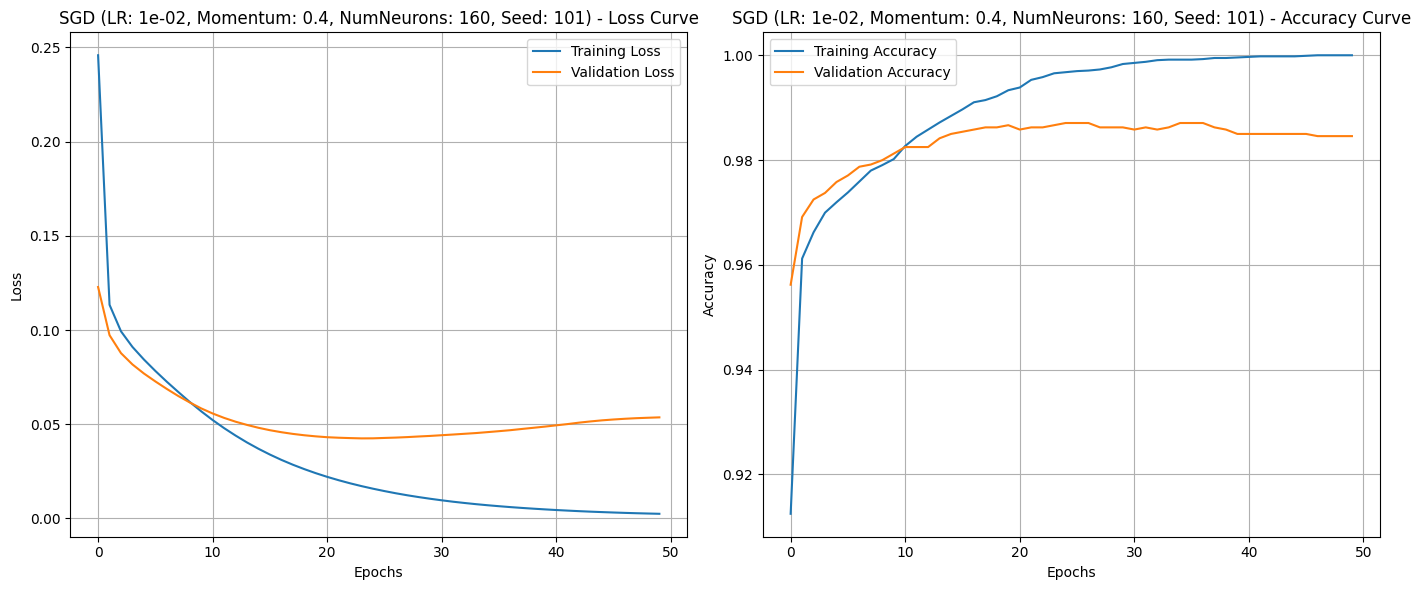

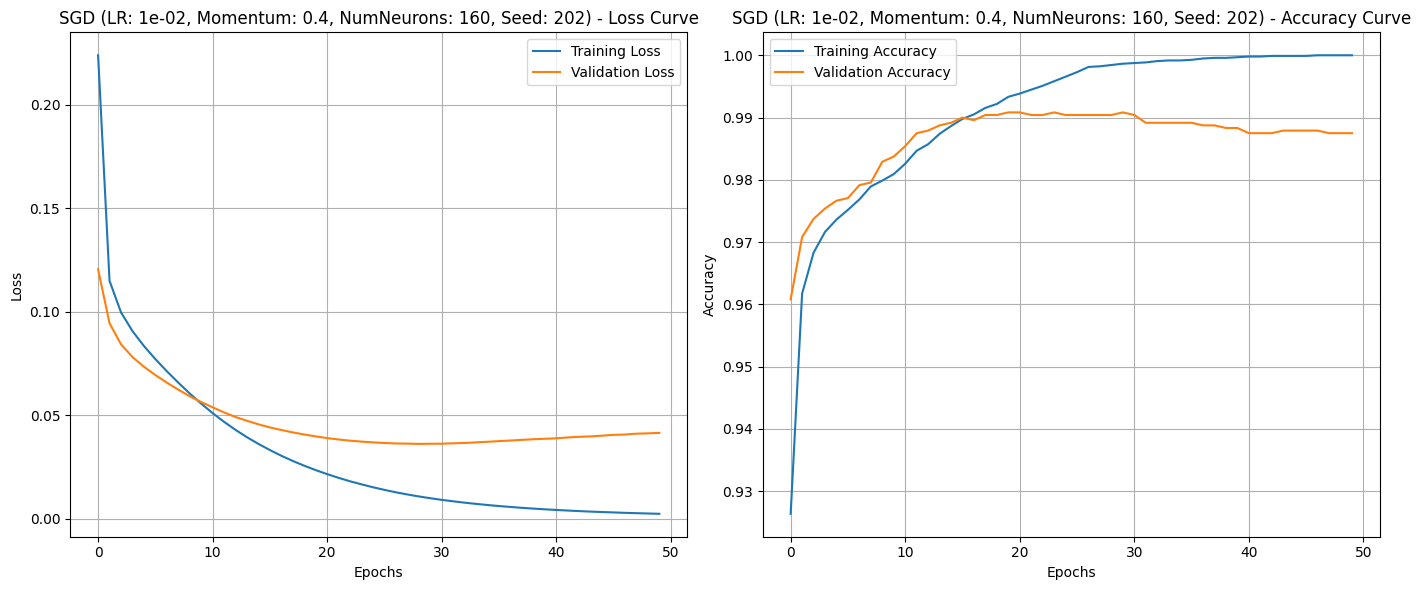

In [39]:
print("\n--- Generating Training History Plots for Final SGD Experiments ---")
for exp_name, history_obj in all_final_sgd_histories.items():
    config_index = int(exp_name.split('_')[-1])
    if config_index < len(final_sgd_experiment_configs):
        current_config = final_sgd_experiment_configs[config_index]
        title = f"SGD (LR: {current_config['learning_rate']:.0e}, Momentum: {current_config['momentum']:.1f}, NumNeurons: {current_config.get('num_neurons_h1', current_config.get('units_0'))}, Seed: {current_config['random_seed']})"
    else:
        title = f"SGD Experiment {config_index}"
    plot_history(history_obj, title_prefix=title)


--- Generating Training History Plots for Final Adam Experiments ---


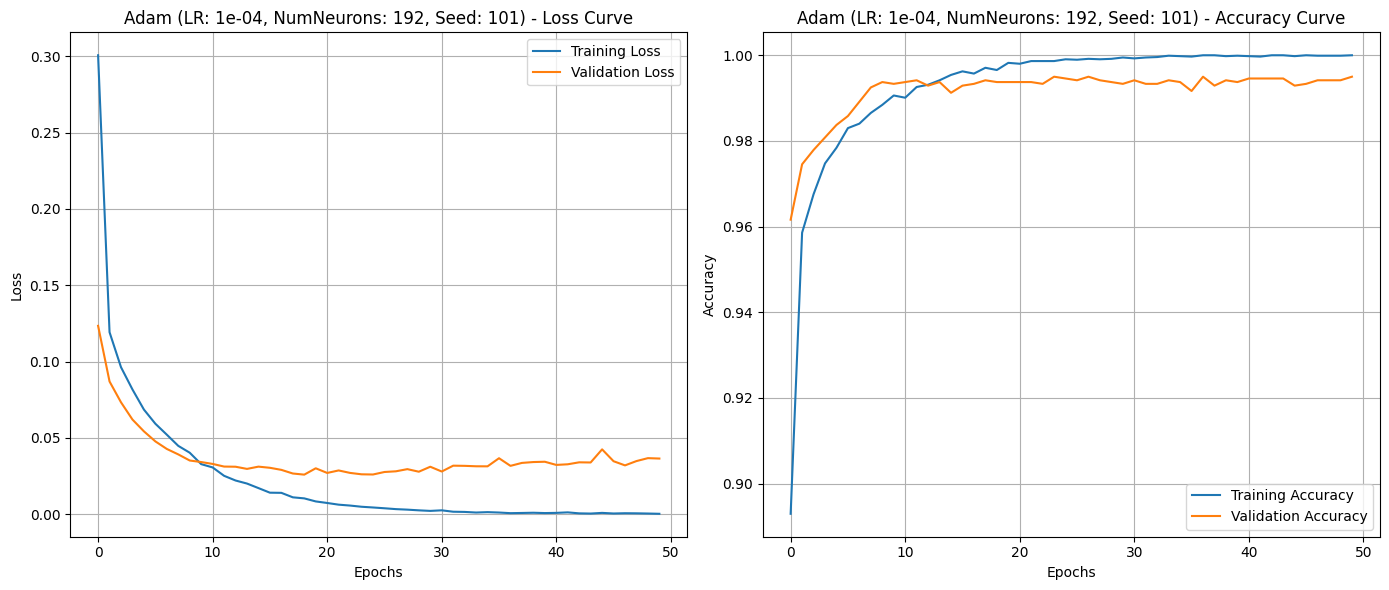

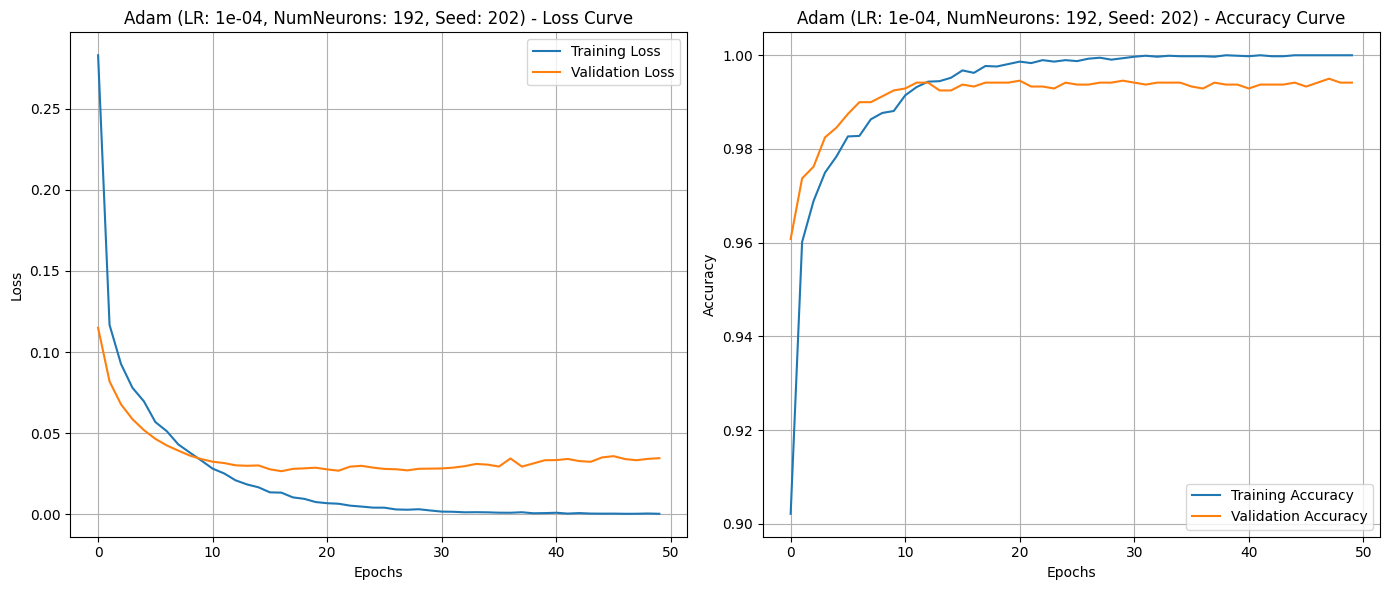

In [40]:
print("\n--- Generating Training History Plots for Final Adam Experiments ---")
for exp_name, history_obj in all_final_adam_histories.items():
    config_index = int(exp_name.split('_')[-1])
    if config_index < len(final_adam_experiment_configs):
        current_config = final_adam_experiment_configs[config_index]
        title = f"Adam (LR: {current_config['learning_rate']:.0e}, NumNeurons: {current_config.get('num_neurons_h1', current_config.get('units_0'))}, Seed: {current_config['random_seed']})"
    else:
        title = f"Adam Experiment {config_index}"
    plot_history(history_obj, title_prefix=title)